In [34]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [35]:
## Import dependencies
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization, Bidirectional, Conv1D
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta

In [36]:
file = "/content/drive/MyDrive/TFM UNIR/Glucose Level - T1D - FreeStyle Libre.csv"

In [37]:
df = pd.read_csv(file)
df

,ID,Date,Glucose level
0,LIB193263,2020-06-09 19:08:00,99.0
1,LIB193263,2020-06-09 19:23:00,92.0
2,LIB193263,2020-06-09 19:38:00,86.0
3,LIB193263,2020-06-09 19:53:00,85.0
4,LIB193263,2020-06-09 20:08:00,85.0
...,...,...,...
2999996,LIB193399,2020-10-20 20:50:00,83.0
2999997,LIB193399,2020-10-20 21:05:00,76.0
2999998,LIB193399,2020-10-20 21:20:00,67.0
2999999,LIB193399,2020-10-20 21:35:00,63.0


In [38]:
from datetime import datetime, timedelta
# Return a dataframe filtered by patient id, between two dates and remove dulpied and useless data
def delete_useless_intervals_by_patient_window(df, id, init_date, finish_date):
    # Filter dataframe by patient id and start date and finish date
    df_patient = df[(df['ID'] == id) & (df['Date'] >= init_date) & (df['Date'] <= finish_date)]
    # Delete duplied rows
    filtered_patient = df_patient.drop_duplicates(subset='Date')
    filtered_patient = filtered_patient.reset_index(drop=True)
    
    # Delete small intervals
    time_before = filtered_patient.iloc[0]['Date']
    for index, row in filtered_patient.iterrows():
      if index > 0:
        d1 = datetime.strptime(time_before, "%Y-%m-%d %H:%M:%S")
        d2 = datetime.strptime(row['Date'], "%Y-%m-%d %H:%M:%S")
        time_difference = d2 - d1
        time_difference = time_difference.total_seconds() / 60
        if time_difference <= 7:
          filtered_patient = filtered_patient.drop(index)
        time_before = row['Date']

    filtered_patient = filtered_patient.reset_index(drop=True)
    return filtered_patient

In [39]:
# Return the dataframe with empty intervals added with interpolated values using cubic spline method
def interpolate_patient_window(id, patient_df):
  intervals_to_add = []
  n_of_intervals = 0
  for index, row in patient_df.iterrows():
    if index > 0:
      time_before = patient_df.loc[index-1]['Date']
      d1 = datetime.strptime(time_before, "%Y-%m-%d %H:%M:%S")
      d2 = datetime.strptime(row['Date'], "%Y-%m-%d %H:%M:%S")
      time_difference = d2 - d1
      # Calculate interval in minutes
      time_difference = time_difference.total_seconds() / 60
      if time_difference > 25:
        current_date = d1
        while(current_date < (d2 - timedelta(minutes=15))):
          current_date = current_date + timedelta(minutes=15)
          intervals_to_add.append((current_date.strftime("%Y-%m-%d %H:%M:%S"), (index + n_of_intervals)))
          n_of_intervals += 1

  print("For patient: ", id, " we have added ", n_of_intervals, "readings")
  for interval in intervals_to_add:
      new_row = pd.DataFrame([[id, interval[0], None]], columns=patient_df.columns, index=[interval[1]])
      patient_df = pd.concat([patient_df.iloc[:interval[1]], new_row, patient_df.iloc[interval[1]:]]).reset_index(drop=True)
    
  # Interpolate empty values on column 'Glucose level' using cubic spline method
  patient_df['Glucose level'] = patient_df['Glucose level'].interpolate(method='spline', order=3)
  return patient_df

In [40]:
# Best window from best 5 patients

# Patient:  LIB193385  best window:  2021-08-22 23:41:00  -  2021-11-08 22:22:00 -->  7424  readings
# Patient:  LIB193327  best window:  2021-01-13 02:28:00  -  2021-03-27 01:52:00 -->  6942  readings
# Patient:  LIB193313  best window:  2021-05-11 17:37:00  -  2021-07-03 15:19:00 -->  4543  readings
# Patient:  LIB193316  best window:  2022-01-27 09:47:00  -  2022-03-10 09:47:00 -->  4007  readings
# Patient:  LIB193367  best window:  2021-04-05 22:49:00  -  2021-05-17 22:31:00 -->  3988  readings

best_patients = [('LIB193385', '2021-08-22 23:41:00', '2021-11-08 22:22:00'),
            ('LIB193327', '2021-01-13 02:28:00', '2021-03-27 01:52:00'),
            ('LIB193313', '2021-05-11 17:37:00', '2021-07-03 15:19:00'),
            ('LIB193316', '2022-01-27 09:47:00', '2022-03-10 09:47:00'),
            ('LIB193367', '2021-04-05 22:49:00', '2021-05-17 22:31:00'),
          ]

# For best windows treat the data
patients_dict = {elem[0] : pd.DataFrame() for elem in best_patients}
for patient in best_patients:
  patient_df = delete_useless_intervals_by_patient_window(df, patient[0], patient[1], patient[2])
  patient_df_interpolated = interpolate_patient_window(patient[0], patient_df)
  patients_dict[patient[0]] = patient_df_interpolated[["Date","Glucose level"]].reset_index(drop=True)

For patient:  LIB193385  we have added  34 readings
For patient:  LIB193327  we have added  45 readings
For patient:  LIB193313  we have added  514 readings
For patient:  LIB193316  we have added  16 readings
For patient:  LIB193367  we have added  18 readings


In [41]:
import matplotlib.pyplot as plt


#This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
#of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 400 or max(pred_values) > 400:
        print("Input Warning: the maximum reference value {} or the maximum prediction value {} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print("Input Warning: the minimum reference value {} or the minimum prediction value {} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='.', color='black', s=8)
    plt.title(title_string + " Clarke Error Grid")
    plt.xlabel("Reference Concentration (mg/dl)")
    plt.ylabel("Prediction Concentration (mg/dl)")
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))

    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                      #Theoretical 45 regression line
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    #plt.plot([175/3, 320], [70, 400], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    # plt.plot([70, 70], [0, 175/3], '-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
    # plt.plot([70, 400],[175/3, 320],'-', c='black')
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return plt, zone

In [42]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               df,
               label_columns=None):
    ## Transform data. 
    ## Erase date column 
    ##df = df.drop(columns=['Date'], inplace=True)

    ## Create train & test
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [43]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [44]:
# For each window create timeseries dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [45]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get an example batch of `inputs, labels` for plotting."""
  result = next(iter(self.train))
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [46]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
###  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
###                                                    patience=patience,
###                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS, batch_size = 32, shuffle = False,
                      validation_data=window.val)
###                      ,callbacks=[early_stopping])
  
  # Make arround of 1000 predictions and plot clarke error grid
  predictions_values = []
  ref_values = []
  i = 0
  while i < 31:
    inputs, label = window.example
    predictions = model(inputs)
    for p in predictions:
      predictions_values.append(p[0])
    for l in label:
      ref_values.append(l[0])
    i += 1
  plot, zone = clarke_error_grid(ref_values, predictions_values, "")
  plot.show()
  return history

In [47]:
## Model LSTM
monoLSTM = Sequential()
monoLSTM.add(LSTM(128))
monoLSTM.add(Dense(150, activation = 'relu'))
monoLSTM.add(Dropout(0.20))
monoLSTM.add(Dense(100, activation = 'relu'))
monoLSTM.add(Dropout(0.15))
monoLSTM.add(Dense(50, activation = 'relu'))
monoLSTM.add(Dense(20, activation = 'relu'))
monoLSTM.add(Dense(1, activation = 'relu'))

## Model BiLSTM
BiLSTM = Sequential()
BiLSTM.add(Bidirectional(LSTM(128)))
BiLSTM.add(Dense(150, activation = 'relu'))
BiLSTM.add(Dropout(0.20))
BiLSTM.add(Dense(100, activation = 'relu'))
BiLSTM.add(Dropout(0.15))
BiLSTM.add(Dense(50, activation = 'relu'))
BiLSTM.add(Dense(20, activation = 'relu'))
BiLSTM.add(Dense(1, activation = 'relu'))

## Model CONV
CONV = Sequential()
CONV.add(Conv1D(filters = 32, kernel_size = 1, activation = 'relu'))
CONV.add(LSTM(128, return_sequences = False))
CONV.add(Dense(150, activation = 'relu'))
CONV.add(Dropout(0.2))
CONV.add(Dense(100, activation = 'relu'))
CONV.add(Dropout(0.15))
CONV.add(Dense(50, activation = 'relu'))
CONV.add(Dense(16, activation = 'relu'))
CONV.add(Dense(1, activation = 'relu'))

modelsList = {"monoLSTM": monoLSTM,
               "BiLSTM": BiLSTM,
               "CONV": CONV}

In [48]:
def evaluate_model (window):
  val_performance = {}
  performance = {}
  metrics = {}

  for name in modelsList:
    print ("Evaluación "+ name)
    model = modelsList[name]
    history = compile_and_fit(model, window)
    val_performance[name] = model.evaluate(window.val)
    performance[name] = model.evaluate(window.test, verbose=0)

  for metric in model.metrics_names:
      x = np.arange(len(performance))
      width = 0.3
      metric_name = metric
      metric_index = model.metrics_names.index(metric)
      val = [v[metric_index] for v in val_performance.values()]
      test = [v[metric_index] for v in performance.values()]
      metrics[metric] = (val, test)

      plt.figure()
      plt.title(metric)
      plt.ylabel(metric)
      plt.bar(x - 0.17, val, width, label='Validation')
      plt.bar(x + 0.17, test, width, label='Test')
      plt.xticks(ticks=x, labels=performance.keys(),
                rotation=45)
      _ = plt.legend()
      plt.show()

  return metrics

In [49]:
# Evaluate a patient dataframe with windows of 30, 60, 90 and 180 minutes
def evaluate_window (patient_df):
  window_60 = WindowGenerator(input_width=8, label_width=1, shift=4, df=patient_df['Glucose level'].to_frame(),
                     label_columns=['Glucose level'])

  window_30 = WindowGenerator(input_width=8, label_width=1, shift=2, df=patient_df['Glucose level'].to_frame(),
                     label_columns=['Glucose level'])
  
  window_90 = WindowGenerator(input_width=24, label_width=1, shift=6, df=patient_df['Glucose level'].to_frame(),
                     label_columns=['Glucose level'])

  window_180 = WindowGenerator(input_width=24, label_width=1, shift=12, df=patient_df['Glucose level'].to_frame(),
                     label_columns=['Glucose level'])
  
  windows={"window_30" : window_30,
            "window_60" : window_60,
            "window_90" : window_90,
            "window_180" : window_180}

  results = {}
  for window in windows:
    print("Predicción de " + window)
    results[ventana] = evaluate_model(windows[window])

  return results

Predicción de window_30
Evaluación monoLSTM
Epoch 1/100
163/163 [==============================] - 8s 29ms/step - loss: 3681.0393 - mean_absolute_error: 41.2032 - mean_squared_error: 3681.0393 - root_mean_squared_error: 60.6716 - val_loss: 204.0528 - val_mean_absolute_error: 10.1347 - val_mean_squared_error: 204.0528 - val_root_mean_squared_error: 14.2847
Epoch 2/100
163/163 [==============================] - 4s 22ms/step - loss: 368.9288 - mean_absolute_error: 14.7075 - mean_squared_error: 368.9288 - root_mean_squared_error: 19.2075 - val_loss: 175.6201 - val_mean_absolute_error: 9.3351 - val_mean_squared_error: 175.6201 - val_root_mean_squared_error: 13.2522
Epoch 3/100
163/163 [==============================] - 4s 22ms/step - loss: 373.5371 - mean_absolute_error: 14.7861 - mean_squared_error: 373.5371 - root_mean_squared_error: 19.3271 - val_loss: 174.7355 - val_mean_absolute_error: 9.2747 - val_mean_squared_error: 174.7355 - val_root_mean_squared_error: 13.2188
Epoch 4/100
163/163 

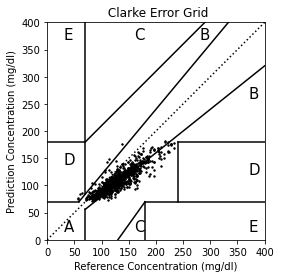

47/47 [==============================] - 0s 9ms/step - loss: 477.4659 - mean_absolute_error: 18.6497 - mean_squared_error: 477.4659 - root_mean_squared_error: 21.8510
Evaluación BiLSTM
Epoch 1/100
163/163 [==============================] - 11s 39ms/step - loss: 3222.4282 - mean_absolute_error: 38.9812 - mean_squared_error: 3222.4282 - root_mean_squared_error: 56.7664 - val_loss: 211.4726 - val_mean_absolute_error: 11.2741 - val_mean_squared_error: 211.4726 - val_root_mean_squared_error: 14.5421
Epoch 2/100
163/163 [==============================] - 5s 32ms/step - loss: 419.5257 - mean_absolute_error: 15.7243 - mean_squared_error: 419.5257 - root_mean_squared_error: 20.4823 - val_loss: 191.7775 - val_mean_absolute_error: 9.8491 - val_mean_squared_error: 191.7775 - val_root_mean_squared_error: 13.8484
Epoch 3/100
163/163 [==============================] - 5s 33ms/step - loss: 376.0798 - mean_absolute_error: 14.7492 - mean_squared_error: 376.0798 - root_mean_squared_error: 19.3928 - val_l

In [ ]:
metric_results = {}
for patient_id, patient_df in patients_dict.items():
  metric_results[patient_id] = evaluate_window(patient_df)

print(metric_results)